## Constructing a riskless spot rate curve for Euro
The first thing we need to do to price any option on an equity priced in Euro is construct the so-called riskless sport rate (aka zero-rate) curve for Euro. This is because pricing of derivatives is done in _the risk-neutral world_ where all investors are assumed not to require a premium for additional risks, hence future cashflows are discounted using the riskless rate to obtain their NPV.

I use [the ECB's daily Euro area yield curve](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html) as a proxy for riskfree rates. These rates are derived from AAA-rated government bonds of the Euro area. Ideally, using swap rates might be better as government bond yields tend to be 3-4 basis points lower given that government bonds tend to be heavily used in repo trades. See [this ECB note](https://www.ecb.europa.eu/pub/pdf/scpsps/ecb.sps27.en.pdf) for more details.

I use the following dataseries provided by the [ECB](https://data.ecb.europa.eu/data/data-categories):
* `YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_<maturity_designator>`. [This series](https://data.ecb.europa.eu/data/datasets/YC?dataset%5B0%5D=Financial%20market%20data%20-%20yield%20curve%20%28YC%29&filterSequence=dataset&advFilterDataset%5B0%5D=Financial%20market%20data%20-%20yield%20curve%20%28YC%29) returns spot rates that the ECB derives from yields on AAA-rated government bonds of the Euro Area that it calculates on every TARGET business day. The returned rates are presented using Annual percentage rates and represent the average over a given business day. [The ECB uses continuous compounding](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf) when calculating them. **NB**: In the past I obtained these data useing [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database), however due to delays in Eurostat updating its database, I switched to retrieving these data directly from the ECB.
* `FM.B.U2.EUR.4F.KR.DFR.LEV` &mdash; ECB Deposit Facility Rate (DFR) for Euro Area (daily frequency). I use the lower of the ECB Deposit Facility Rate and €STR as a proxy for the riskfree overnight rate.
* `EST.B.EU000A2X2A25.WT` &mdash; €STR, Euro short-term rate - Volume-weighted trimmed mean rate (daily frequency). I use the lower of €STR and the DFR as a proxy for the riskfree overnight rate.

I construct the Euro riskfree curve using 40 curve points with the following terms (which is pretty good for accurate pricing):
* Overnight rate from the ECB Deposit Facility Rate for Euro Area series (adjusted for the actual/actual day count convention)
* 3-, 4-, 5-, 6-, 7-, 8-, 9-, 10-, 11-months spot rate from the `irt_euryld_d` Euro yield curve series
* 1-, 2-, 3-, ..., 29-, 30-years spot rate from the `irt_euryld_d` Euro yield curve series

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines are pretty advanced.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and sdmx1 libraries
#!pip install pandas-datareader -U
#!pip install sdmx1 -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import yfinance as yfin
from pandas.tseries.offsets import MonthBegin, BDay, DateOffset

import sdmx

from datetime import date
from dateutil.relativedelta import relativedelta

from volatility import parameter_estimators, volatility_trackers
from pricing import curves, options

In [8]:
today = date.today()

# The ECB provides yields for maturities ranging from 3 months till 30 years
month_maturities = range(3, 12)
year_maturities = range(1, 31)
maturities = [(f'SR_{maturity}M', str(maturity)+'M') for maturity in month_maturities]
maturities.extend([(f'SR_{maturity}Y', str(maturity)+'Y') for maturity in year_maturities])
maturities1, maturities2 = zip(*maturities)

ecb = sdmx.Client('ECB')
# Taking the last 5 business days, and converting to decimal fractions
data_msg = ecb.data('YC', key='B.U2.EUR.4F.G_N_A.SV_C_YM.' + '+'.join(maturities1), params={'startPeriod': (today-BDay(5)).date()})
euro_curves = sdmx.to_pandas(data_msg.data[0]) / 100.
euro_curves = euro_curves.loc['B', 'U2', 'EUR', '4F', 'G_N_A', 'SV_C_YM'].unstack(level=-2) if isinstance(euro_curves, pd.DataFrame)\
    else euro_curves.loc[slice(None), 'B', 'U2', 'EUR', '4F', 'G_N_A', 'SV_C_YM'].unstack('DATA_TYPE_FM')
euro_spot_rates = euro_curves.set_axis(pd.DatetimeIndex(euro_curves.index))  #, 'B'))
euro_spot_rates = euro_spot_rates.loc[:, maturities1]
euro_spot_rates.columns = maturities2

# Taking the last 5 business days, and converting to decimal fractions
# Retrieving the most recent ECB Deposit Facility Rate, and converting to decimal fractions
data_msg = ecb.data('FM', key='B.U2.EUR.4F.KR.DFR.LEV', params={'startPeriod': today-relativedelta(years=2)})
ecb_deposit_rate = sdmx.to_pandas(data_msg.data[0]) / 100.
ecb_deposit_rate = ecb_deposit_rate.loc['B', 'U2', 'EUR', '4F', 'KR', 'DFR', 'LEV'] if isinstance(ecb_deposit_rate, pd.DataFrame)\
    else ecb_deposit_rate.loc[slice(None), 'B', 'U2', 'EUR', '4F', 'KR', 'DFR', 'LEV']
ecb_deposit_rate = ecb_deposit_rate.set_axis(pd.DatetimeIndex(ecb_deposit_rate.index))
ecb_deposit_rate = pd.concat([ecb_deposit_rate, pd.Series(index=euro_spot_rates.index.difference(ecb_deposit_rate.index))])
ecb_deposit_rate = ecb_deposit_rate.ffill().loc[euro_spot_rates.index[0]:]

# The €STR rate
data_msg = ecb.data('EST', key='B.EU000A2X2A25.WT', params={'startPeriod': today-relativedelta(years=2)})
overnight_rate = sdmx.to_pandas(data_msg.data[0]) / 100.
overnight_rate = overnight_rate.loc['B', 'EU000A2X2A25', 'WT'] if isinstance(overnight_rate, pd.DataFrame)\
    else overnight_rate.loc[slice(None), 'B', 'EU000A2X2A25', 'WT']
overnight_rate = overnight_rate.set_axis(pd.DatetimeIndex(overnight_rate.index)).loc[euro_spot_rates.index[0]:]
if not overnight_rate.index.difference(ecb_deposit_rate.index).empty:
    overnight_rate = overnight_rate.loc[ecb_deposit_rate.index]

# Using a minimum of the €STR and DFR rates
overnight_rate = pd.concat([overnight_rate, ecb_deposit_rate], axis=1).min(axis=1)

In [9]:
# Converting ECB Deposit rates from actual/360 to actual/actual and then to a continuous compounding frequency
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
overnight_rate[leap_year_cond(overnight_rate.index)] *= 366. / 360
overnight_rate[np.invert(leap_year_cond(overnight_rate.index))] *= 365. / 360

# From annual to continuous compounding
overnight_rate = np.log(1 + overnight_rate)

In [10]:
date_now = euro_spot_rates.index[-1].date()
offsets = [DateOffset(months=+maturity) for maturity in month_maturities]
offsets.extend([DateOffset(years=+maturity) for maturity in year_maturities])
offsets = [DateOffset(0)] + offsets

In [11]:
# Define the riskless yield curve for Euro
curve = curves.YieldCurve(today, offsets,
        np.append(
            overnight_rate.loc[euro_spot_rates.index[-1]],
            euro_spot_rates.iloc[-1].to_numpy()),
        compounding_freq=0)

### Optional: Visualizing the riskless yield curve for Euro
The rates presented use a continuous compounding frequency.

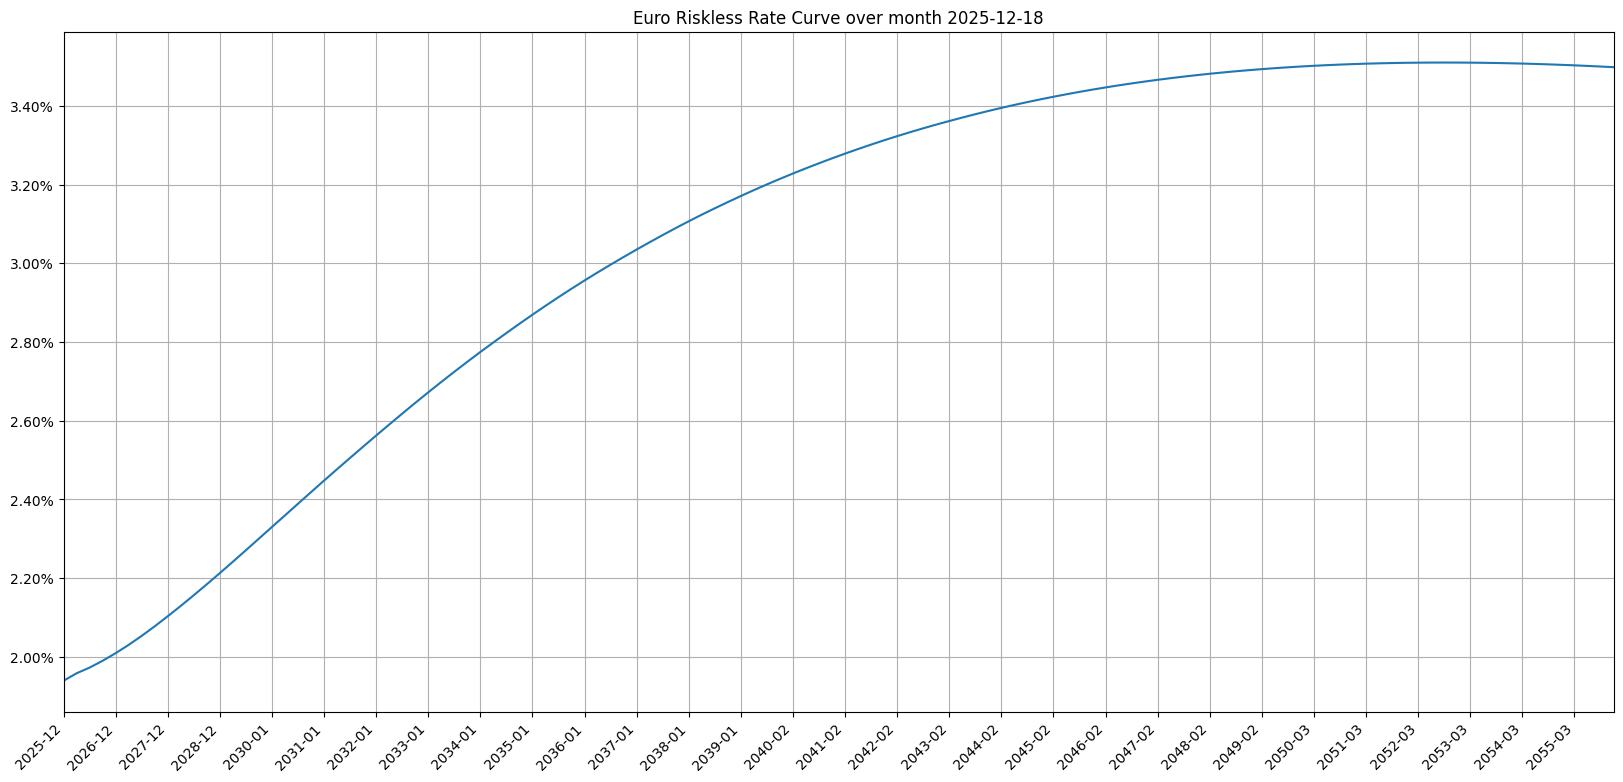

In [12]:
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True,
                       title='Euro Riskless Rate Curve over month ' + euro_spot_rates.index[-1].strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

In [13]:
assert curve.date == BDay(1).rollforward(today).date()